### Марковские процессы
- Скачайте текст войны и мир (ссылка на [github](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.4/war_and_peace) и [гугл диск](https://drive.google.com/drive/u/2/folders/1aM7cNI6Qs7AyeYpQ8lNg7vLsHzIl0JbU)). Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов
- [Выберите ряд](https://datamarket.com/data/list/?q=cat:fpg%20provider:tsdl) и оцените его через HMM. Попробуйте "построить" (через среднее каждой компоненты) наивный прогноз ряда.

In [1]:
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
path = '/home/data/netology_ml/time_series/data/hw 4 (HMM)/'
files = os.listdir(path) 
files = files[1:]

In [3]:
data = []
for text in files:
    with open(path + text, 'r') as f:
        doc = f.read().lower()
    doc = re.sub('[^а-я^ ]','', doc)
    data.append(doc)

In [4]:
data[0][:500]

'лев толстойвойна и миртом   том часть перваяхчасть втораяхчасть третьях  том лев николаевич толстойвойна и миртом часть перваяс конца го года началось усиленное вооружение и сосредоточение сил западной европы и в  году силы эти  миллионы людей считая тех которые перевозили и кормили армию двинулись с запада на восток к границам россии к которым точно так же с го года стягивались силы россии  июня силы западной европы перешли границы россии и началась война то есть совершилось противное человечес'

In [5]:
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(RUSSIAN)}

In [6]:
probabilities_ru = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [7]:
for cp, cn in zip(data[0][:-1], data[0][1:]):
    probabilities_ru[POS[cp], POS[cn]] += 1

In [8]:
probabilities_ru = (probabilities_ru / probabilities_ru.sum(axis=1)[:, None])

In [9]:
#Костыль:
#Для нормальной отрисовки хитмэпа заменил пробел на S
#Если оси будут иметь пробел или спецсимвол, размер букв становится нечитаемым. 
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюяS'

In [10]:
df_ru = pd.DataFrame(probabilities_ru, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

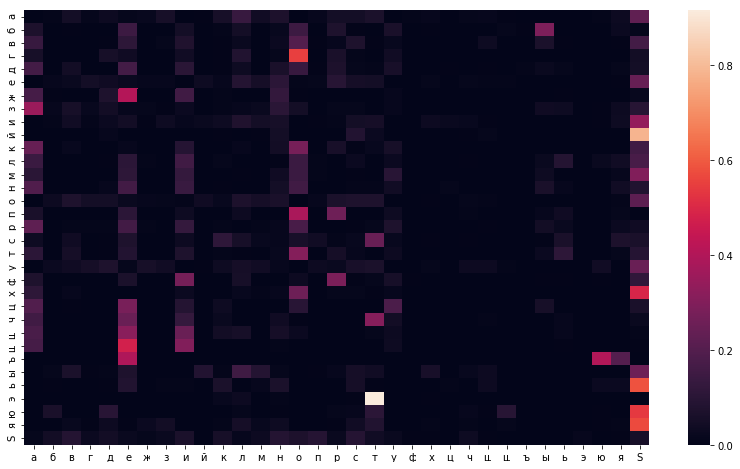

In [11]:
plt.figure(figsize=(14,8))
sns.heatmap(df_ru)
plt.show()
RUSSIAN = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '

Считаем вероятность получить строку "п**р"

In [12]:
start = POS['п']
end = POS['р']
prior = 1. / len(RUSSIAN)
chances = {}
for c1 in RUSSIAN:
    for c2 in RUSSIAN:
        proba = prior * probabilities_ru[start, POS[c1]] * probabilities_ru[POS[c1], POS[c2]]* probabilities_ru[POS[c2], end]
        if proba > 0:
            chances[''.join(['п', c1, c2, 'р'])] = proba

In [13]:
chances['пиар']

5.4780297987836396e-08

Генератор слов на Б из восьми букв

In [14]:
def word_generator(start='б', num=1, length=8):
    for n in range(num):
        s = []
        s.append(start)
        for i in range(length-1):
            index = POS[s[i]]
            next_char = np.random.choice(list(RUSSIAN), p=probabilities_ru[index])
            s.append(next_char)
        print (''.join(s))

In [15]:
word_generator()

бм клабо


### Прогнозируем ряды

In [16]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

In [17]:
dow = pd.read_csv('/home/data/netology_ml/time_series/data/hw 4 (HMM)/dow/weekly-closings-of-the-dowjones-.csv')

In [18]:
dow.columns = ['Week', 'Weekly_closings']

In [19]:
dow = dow.Weekly_closings

In [20]:
def statvis(series, lags=None):
    print('DF-test p-value is', adfuller(series)[1])
    
    fig, ax = plt.subplots(3,1,figsize=(15,12))
    ax[0].plot(series)
    ax[0].grid()
    ax[0].set_title('Series')
    
    m,b = np.polyfit(range(0,len(series)), series, 1) 
    ax[0].plot(range(0,len(series)), m*range(0,len(series))+b, '-r') 
    
    smt.graphics.plot_acf(series, ax=ax[1], alpha=0.05, lags=lags)
    smt.graphics.plot_pacf(series, ax=ax[2], alpha=0.05, lags=lags)

In [21]:
# функция для отрисовки оригинала и модели
def tssplot(series1, series2, labels=['One', 'Two']):
    plt.figure(figsize=(15,5))
    plt.plot(series1, label=labels[0])
    plt.plot(series2, '--r', label=labels[1])
    plt.legend()
    plt.grid()
    return plt.show()

In [22]:
def reverse_stat(series, value, box_cox=0.5):
    un_diff = []
    un_diff = np.append(un_diff, boxcox(value, box_cox))
    for i in range(len(series)):
        un_diff = np.append(un_diff, un_diff[i] + series[i])
    un_box = (un_diff*box_cox+1)**(1/box_cox)
    return un_box

In [23]:
dow_box = boxcox(dow, 0.5)

In [24]:
dow_stat = np.diff(dow_box, 1)

DF-test p-value is 2.54256049952187e-24


/home/data/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


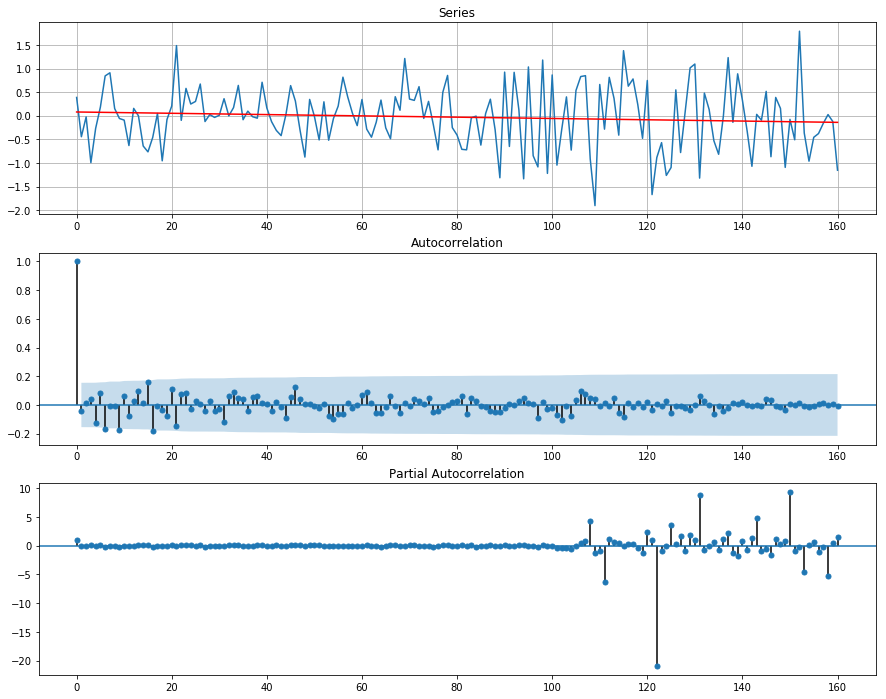

In [25]:
statvis(dow_stat)

In [37]:
from hmmlearn import hmm

In [153]:
values = pd.Series(dow_stat[:-20]).values.reshape(-1,1)

In [77]:
results = []
for n in range(1, 61):
    model = hmm.GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    results.append(model.score(values))

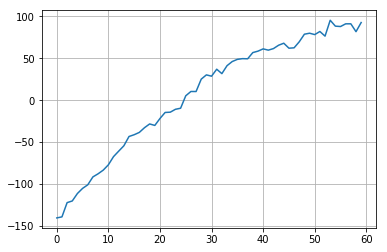

In [78]:
plt.plot(results)
plt.grid()

In [260]:
model = hmm.GaussianHMM(n_components=45,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)

In [261]:
#Предсказываем лейблы
pred = []
pred.append(labels[-1])
for i in range(19):
    next_pred = np.random.choice(range(45), p=model.transmat_[pred[-1]])
    pred.append(next_pred)

In [262]:
#Добавляем предсказанные лейблы к нашим значениям
labels = np.append(labels, pred)

In [263]:
predictions = []
for i in range(len(labels)):
    predictions.append(model.means_[labels[i]])

In [264]:
dow_predict = reverse_stat(predictions, dow[0], box_cox=0.5)

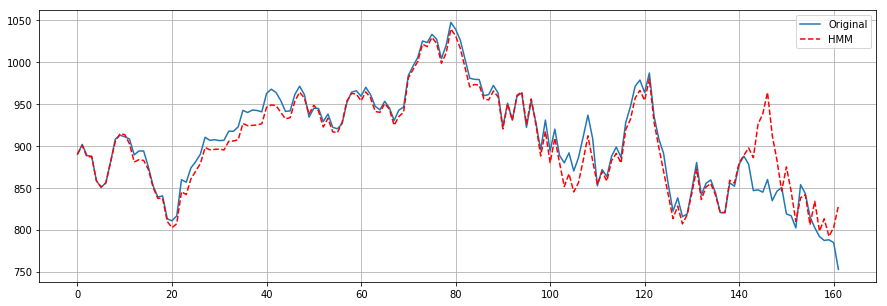

In [265]:
tssplot(dow, dow_predict, ['Original', 'HMM'])

Как видно на графике, предсказания после 140 значения похожи на правду, но стоит понимать, что они получены случайным образом. При запукске модели с другим random_state, результаты будут сильно отличаться.